In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
russell = pd.read_csv('monthly russell Trading Strategy v2.csv')
russell.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,Ask_minus_Bid,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,lasso_pred,pred_forest,log_pred
0,A,2023-03-31,3825,AGILENT TECHNOLOGIES INC,0.598013,0.819430,-0.481976,0.576985,0.687603,0.639317,...,0.090984,9,0,1,1,1,1,0.026907,-0.011182,Positive
1,A,2023-04-30,3826,AGILENT TECHNOLOGIES INC,0.639969,0.569702,-1.002431,0.631267,0.401041,0.631526,...,-0.664249,9,0,0,1,1,1,0.000664,-0.147775,Negative
2,A,2023-05-31,3826,AGILENT TECHNOLOGIES INC,-0.030178,0.559246,0.712503,-0.052604,0.088033,-0.418793,...,1.400101,8,0,0,1,1,1,0.015993,0.090727,Positive
3,A,2023-06-30,3826,AGILENT TECHNOLOGIES INC,-0.685944,0.339669,1.644514,-0.713482,-0.925257,-0.356475,...,-1.519656,8,0,1,1,1,1,0.072084,0.018659,Positive
4,A,2023-07-31,3826,AGILENT TECHNOLOGIES INC,-0.420183,0.339669,0.216209,-0.441817,-0.430748,-0.250592,...,-0.472740,8,0,0,1,0,1,-0.003651,-0.044069,Negative
5,A,2023-08-31,3826,AGILENT TECHNOLOGIES INC,-0.344615,0.339669,-0.038929,-0.364570,-0.431472,-0.131961,...,-0.803705,8,0,0,1,1,0,-0.031294,-0.098616,Negative
6,A,2023-09-30,3826,AGILENT TECHNOLOGIES INC,-0.994696,0.241270,0.416554,-1.025396,-0.888667,-0.721929,...,-0.406939,8,0,0,1,1,1,-0.050909,-0.068743,Negative
7,A,2023-10-31,3826,AGILENT TECHNOLOGIES INC,-1.402365,-1.628310,0.799163,-1.373923,-1.602355,-1.585987,...,0.054647,8,0,1,1,1,1,-0.015450,0.049269,Negative
8,A,2023-11-30,3826,AGILENT TECHNOLOGIES INC,-0.982589,-1.628310,0.986257,-0.940732,-0.543054,-1.340934,...,2.246689,8,0,0,1,0,0,0.033294,0.028259,Positive
9,AA,2023-03-31,3355,ALCOA CORP,1.003492,-1.561951,0.264136,1.013536,1.472161,0.875221,...,2.223777,7,1,1,1,1,1,-0.010301,-0.003921,Positive


In [3]:
russell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17043 entries, 0 to 17042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TICKER             17043 non-null  object 
 1   date               17043 non-null  object 
 2   SICCD              17043 non-null  int64  
 3   COMNAM             17043 non-null  object 
 4   market_cap         17043 non-null  float64
 5   SHROUT             17043 non-null  float64
 6   VOL                17043 non-null  float64
 7   PRC                17043 non-null  float64
 8   ASKHI              17043 non-null  float64
 9   BIDLO              17043 non-null  float64
 10  total              17043 non-null  int64  
 11  negative           17043 non-null  int64  
 12  positive           17043 non-null  int64  
 13  sprtrn             17043 non-null  float64
 14  RET                17043 non-null  float64
 15  next_month_return  17043 non-null  float64
 16  last_month_return  170

In [4]:
# Change date column to datetime with %Y-%m-%d format
russell['date'] = pd.to_datetime(russell['date'], format='%Y-%m-%d')

# Change SICCD column to object
russell['SICCD'] = russell['SICCD'].astype(str)

# Change proper. column to object
russell['proper'] = russell['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(russell.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17043 entries, 0 to 17042
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             17043 non-null  object        
 1   date               17043 non-null  datetime64[ns]
 2   SICCD              17043 non-null  object        
 3   COMNAM             17043 non-null  object        
 4   market_cap         17043 non-null  float64       
 5   SHROUT             17043 non-null  float64       
 6   VOL                17043 non-null  float64       
 7   PRC                17043 non-null  float64       
 8   ASKHI              17043 non-null  float64       
 9   BIDLO              17043 non-null  float64       
 10  total              17043 non-null  int64         
 11  negative           17043 non-null  int64         
 12  positive           17043 non-null  int64         
 13  sprtrn             17043 non-null  float64       
 14  RET   

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
russell.dropna(subset=['next_month_return'], inplace=True)

# Select only numeric columns
numeric_columns = russell.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[russell['next_month_return'] >= 0]
negative_return = numeric_columns[russell['next_month_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_month_return'] = mean_negative_return
result_df['mean_positive_next_month_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                   negative_next_month_return  \
market_cap                              0.193   
SHROUT                                  0.065   
VOL                                    -0.099   
PRC                                     0.188   
ASKHI                                   0.201   
BIDLO                                   0.233   
total                                   4.409   
negative                                0.036   
positive                                0.460   
sprtrn                                 -0.312   
RET                                    -0.180   
next_month_return                      -0.086   
last_month_return                       0.003   
last_month_volume                       0.037   
X1_month_ma                             0.188   
X2_month_ma                             0.297   
X3_month_ma                             0.373   
Ask_minus_Bid                          -0.027   
comp_size                               4.447   
dummy_negative      

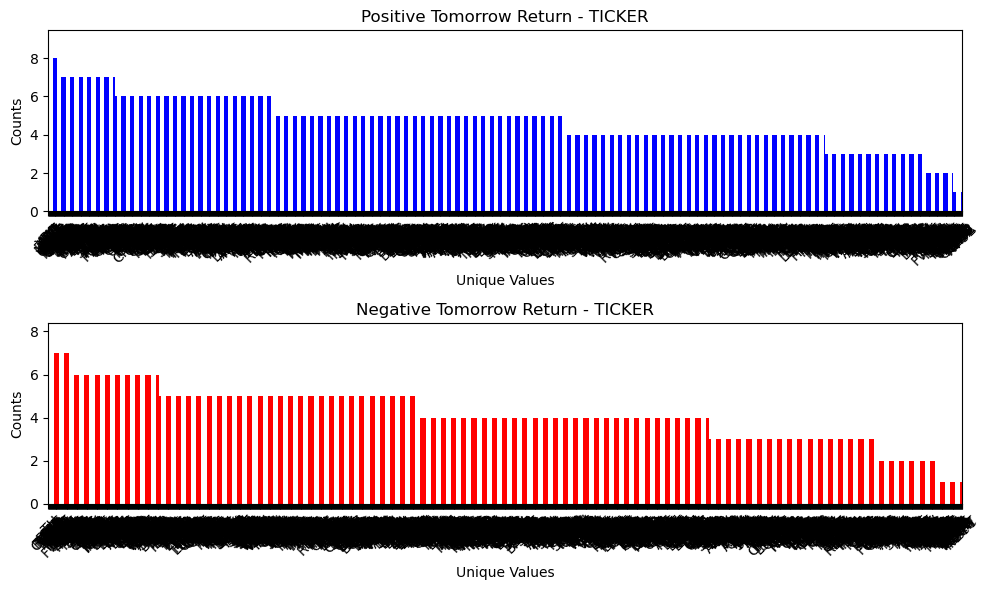

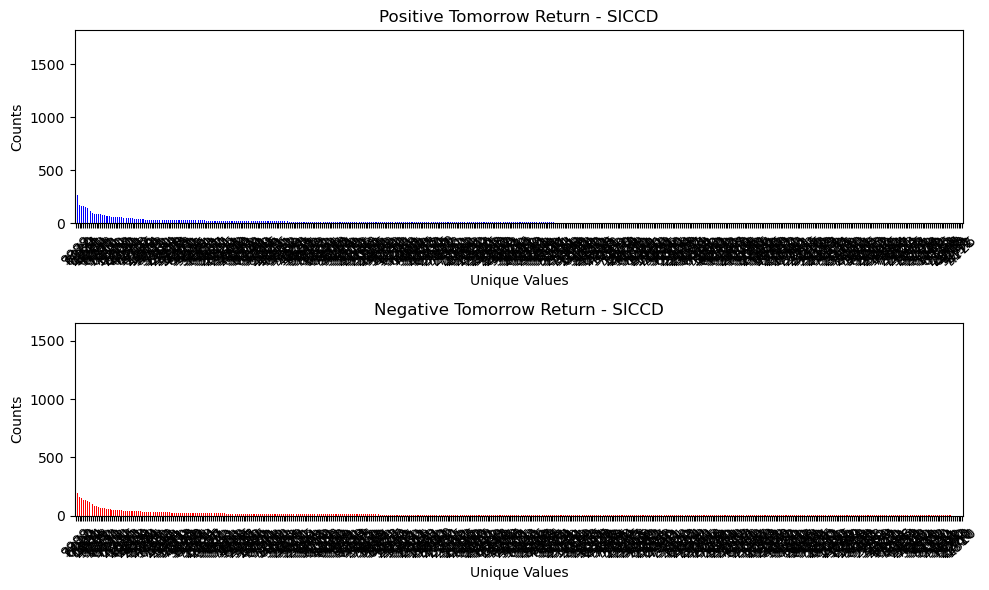

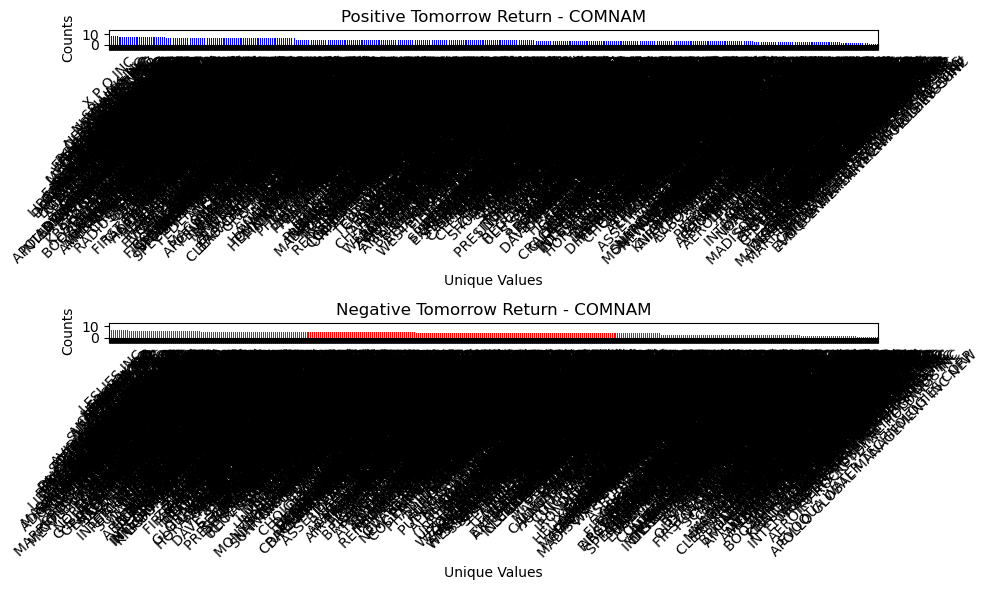

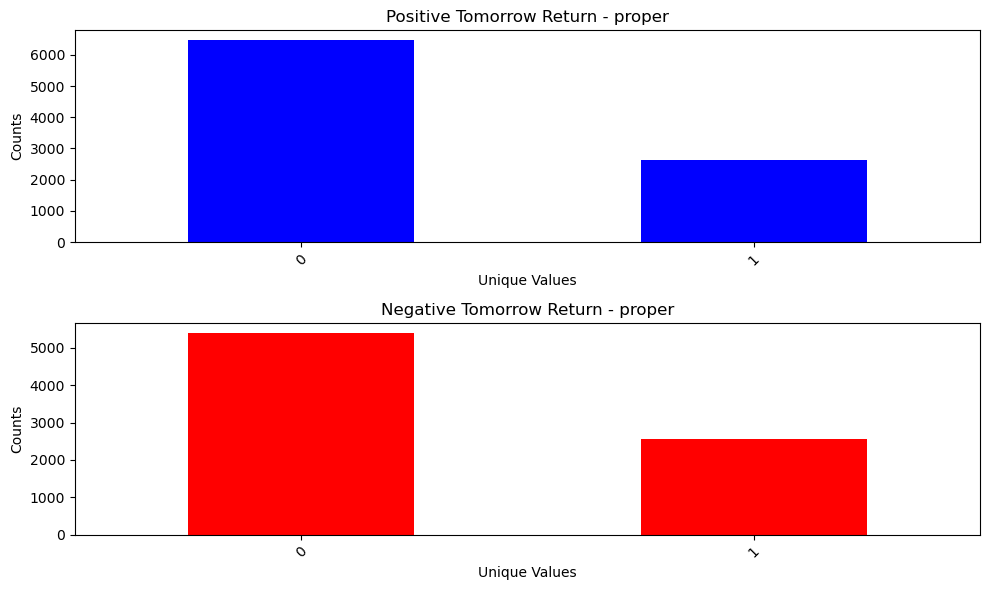

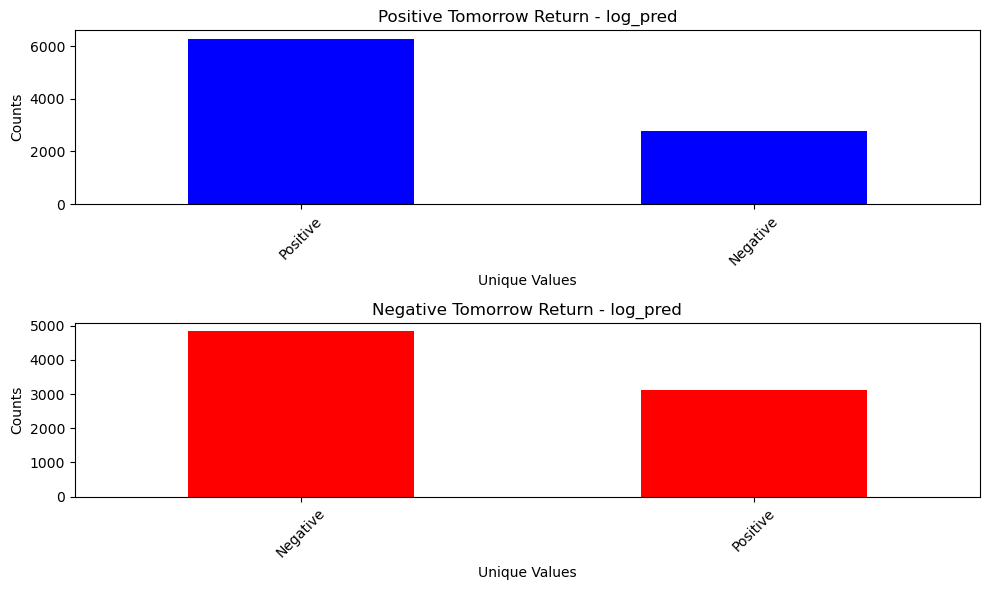

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
russell.dropna(subset=['next_month_return'], inplace=True)

# Select only categorical columns
categorical_columns = russell.select_dtypes(include=['object'])

# Create subsets
positive_return = russell[russell['next_month_return'] >= 0]
negative_return = russell[russell['next_month_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

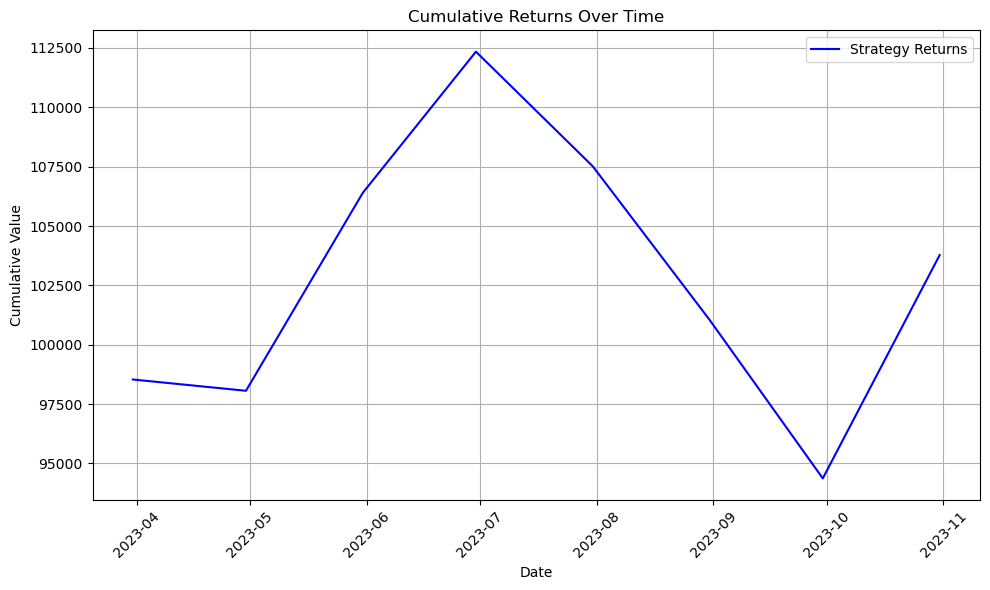

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy.loc[(russell_copy['total'] > 0), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


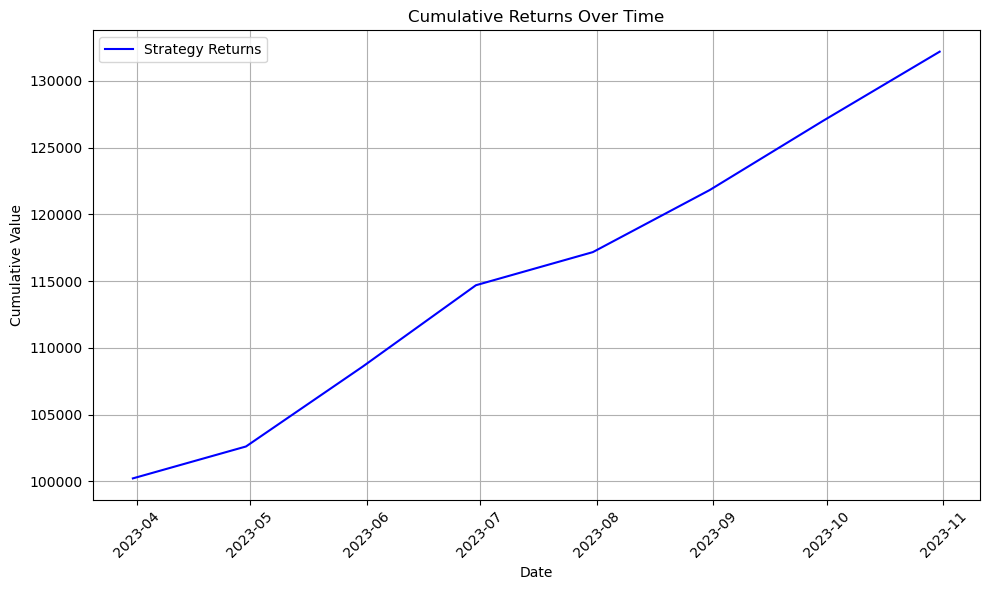

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['lasso_pred'] > 0), 'position'] = 1
russell_copy.loc[(russell_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


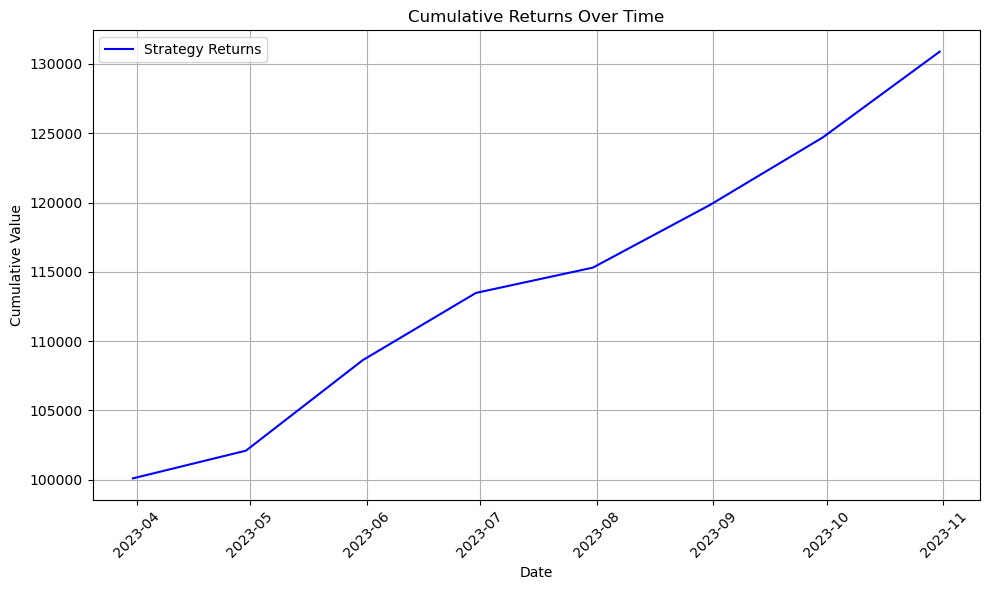

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['lasso_pred'] > 0) & (russell_copy['total'] > 4), 'position'] = 1
russell_copy.loc[(russell_copy['lasso_pred'] < 0) & (russell_copy['total'] > 4), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


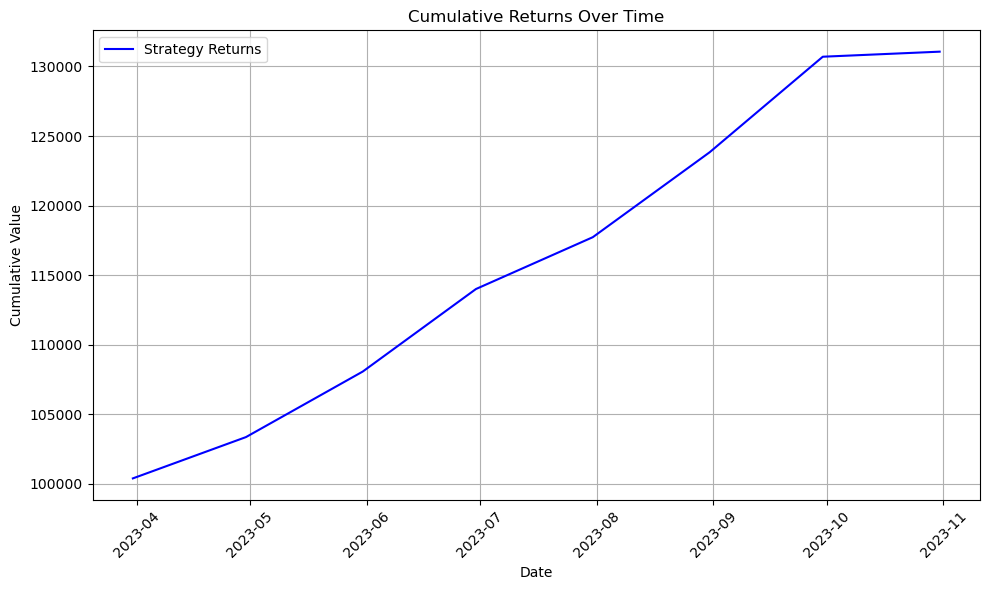

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['log_pred'] == 'Positive'), 'position'] = 1
russell_copy.loc[(russell_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


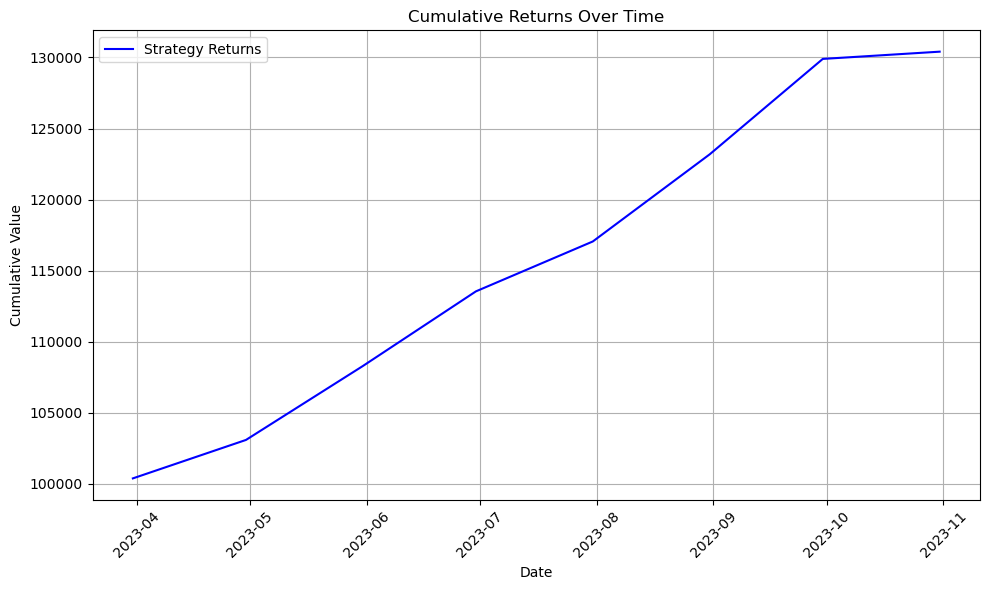

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['log_pred'] == 'Positive') & (russell_copy['total'] > 2), 'position'] = 1
russell_copy.loc[(russell_copy['log_pred'] == 'Negative') & (russell_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


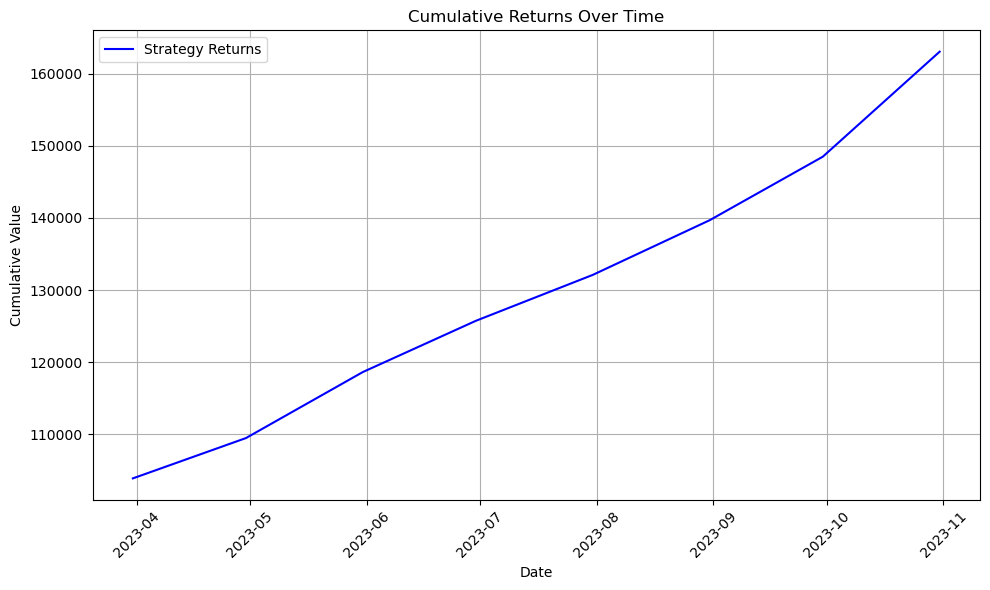

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['pred_forest'] > 0), 'position'] = 1
russell_copy.loc[(russell_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


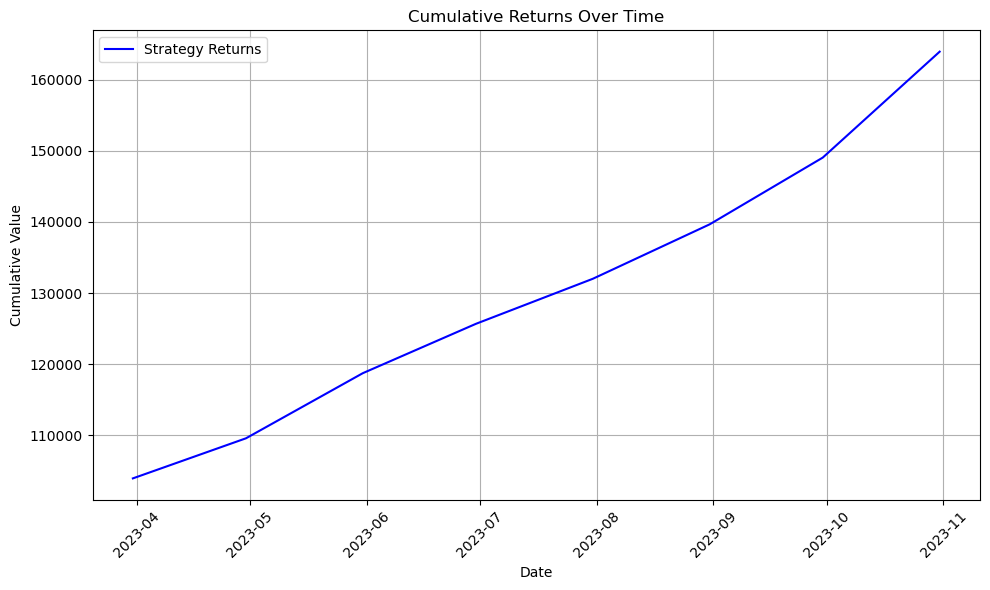

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['pred_forest'] > 0) & (russell_copy['dummy_total'] == 1), 'position'] = 1
russell_copy.loc[(russell_copy['pred_forest'] < 0) & (russell_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


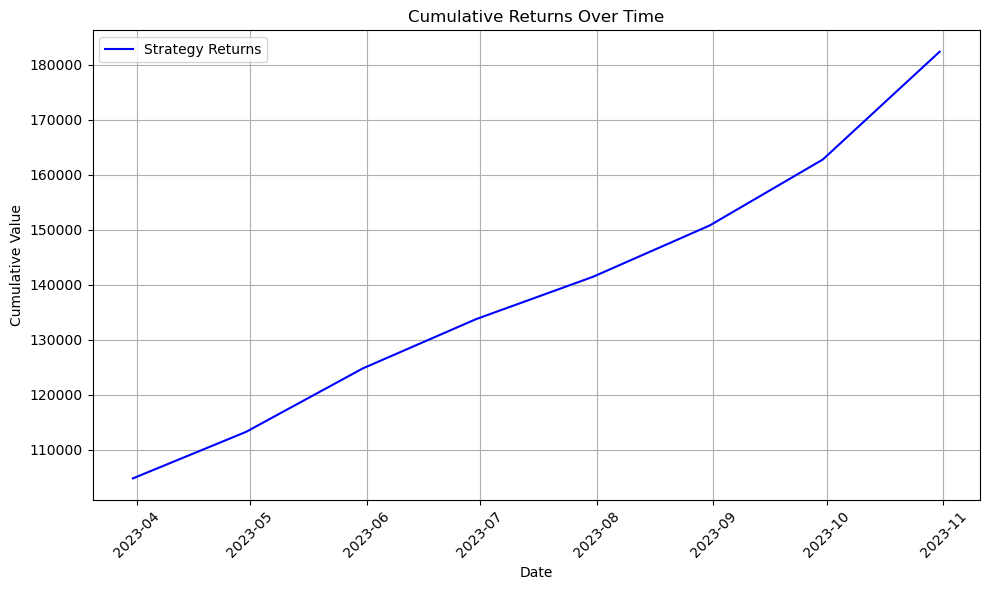

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['pred_forest'] > 0) & (russell_copy['lasso_pred'] > 0) & (russell_copy['dummy_total'] == 1), 'position'] = 1
russell_copy.loc[(russell_copy['pred_forest'] < 0) & (russell_copy['lasso_pred'] < 0) & (russell_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


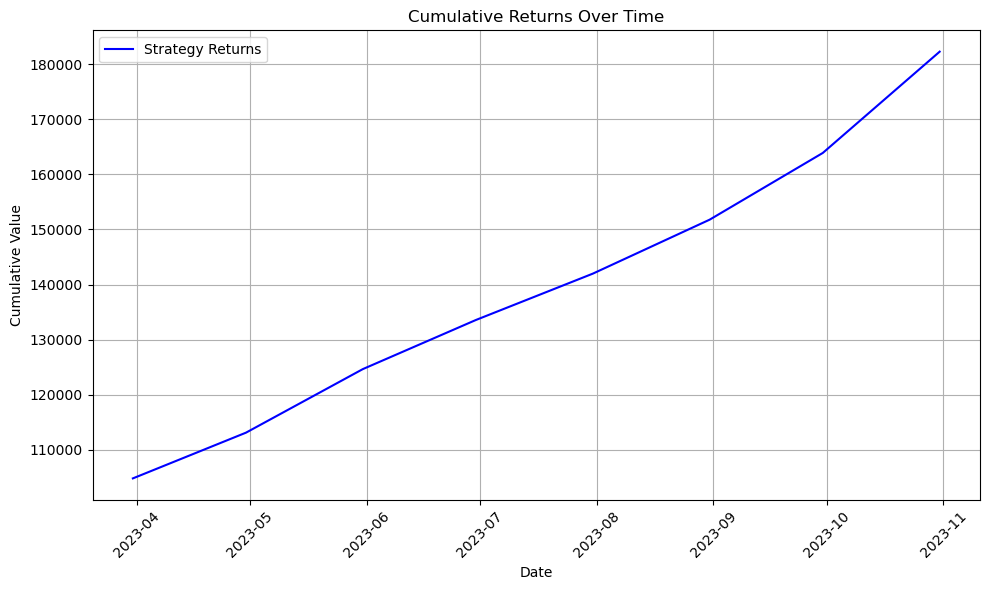

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['pred_forest'] > 0) & (russell_copy['log_pred'] == 'Positive') & (russell_copy['dummy_total'] == 1), 'position'] = 1
russell_copy.loc[(russell_copy['pred_forest'] < 0) & (russell_copy['log_pred'] == 'Negative') & (russell_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


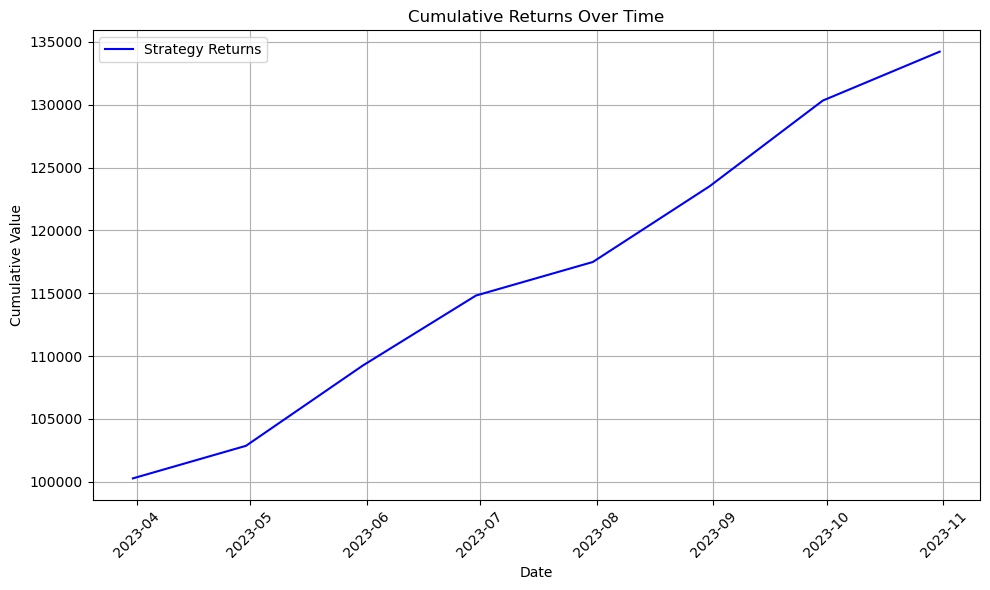

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['log_pred'] == 'Positive') & (russell_copy['lasso_pred'] > 0) & (russell_copy['total'] > 3), 'position'] = 1
russell_copy.loc[(russell_copy['log_pred'] == 'Negative') & (russell_copy['lasso_pred'] < 0) & (russell_copy['total'] > 3), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


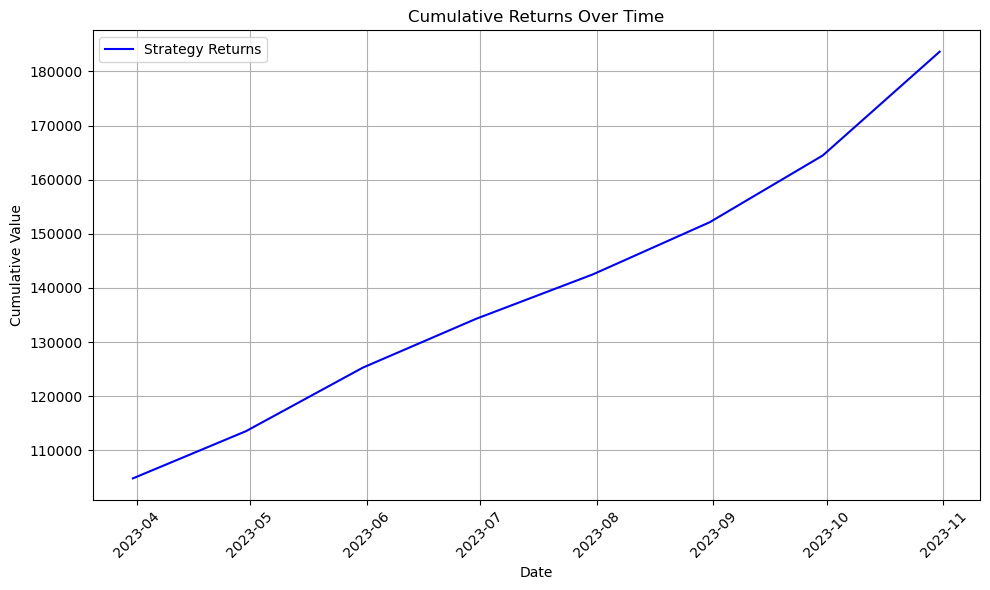

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
russell_copy = russell.copy()

# Convert 'date' column to datetime format
russell_copy['date'] = pd.to_datetime(russell_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
russell_copy = russell_copy[russell_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
russell_copy['position'] = 0
russell_copy.loc[(russell_copy['pred_forest'] > 0) & (russell_copy['lasso_pred'] > 0) & (russell_copy['dummy_total'] == 1) & (russell_copy['log_pred'] == 'Positive'), 'position'] = 1
russell_copy.loc[(russell_copy['pred_forest'] < 0) & (russell_copy['lasso_pred'] < 0) & (russell_copy['dummy_total'] == 1) & (russell_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = russell_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = russell_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = russell_copy[russell_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
